## Building GradCAM

## Import libraries

In [1]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2 # open cv
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Applying GradCAM

### Get Images and import helper functions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Deep Learning/

/content/drive/MyDrive/Colab Notebooks/Deep Learning


In [7]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Deep Learning/cnn_helper')

import cnn_helper as hp

### Load and Pre-process Image for VGG19 interpretation

In [5]:
train_ds, val_ds = hp.prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


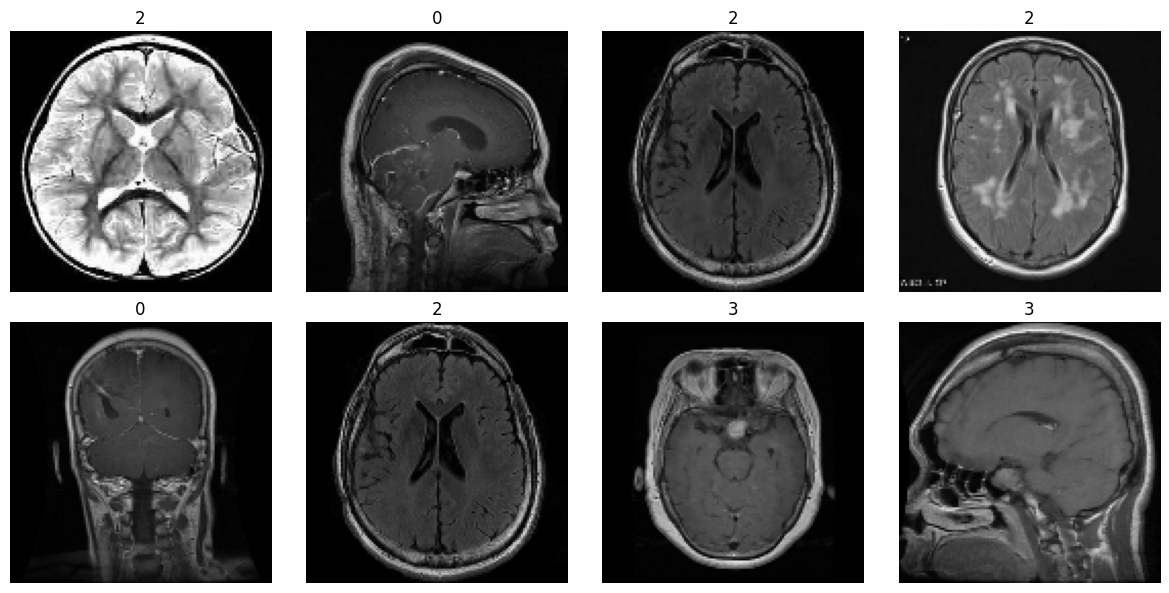

In [6]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

### Run VGG Inference

In [8]:
file_path = "/content/drive/My Drive/Colab Notebooks/Deep Learning/model_vgg.keras"

In [9]:
vgg_model = tf.keras.models.load_model(file_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
for image, label in train_ds.take(1):
  test_image = image[0]

In [11]:
test_image = np.expand_dims(test_image, axis=0)

In [12]:
# use the network to make predictions on the input image and find
preds = vgg_model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [13]:
preds.shape

(1, 4)

In [14]:
preds

array([[0.08419619, 0.00682537, 0.78755444, 0.12142397]], dtype=float32)

In [15]:
np.argmax(preds)

2

In [16]:
np.argmax(preds)
preds[0][2]

0.78755444

In [17]:
preds[0][1]

0.0068253684

In [18]:
# get classes
idx, decoded = gp.get_class_predictions(preds, 0)

Class with highest probability:
notumor: 78.76%


### Initialize GradCAM instance

In [20]:
from gradcam_keras import GradCAM

In [21]:
for layer in vgg_model.layers:
    print(layer.name, layer)


functional_44 <Functional name=functional_44, built=True>
global_average_pooling2d_2 <GlobalAveragePooling2D name=global_average_pooling2d_2, built=True>
dropout_14 <Dropout name=dropout_14, built=True>
dense_8 <Dense name=dense_8, built=True>


In [22]:
base_model = vgg_model.get_layer("functional_44")  # Get the VGG19 base model
for layer in base_model.layers:
    print(layer.name)

input_layer_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4


In [24]:
vgg_gc = GradCAM(model=base_model, classIdx=2, layerName="block5_conv4")

### Get GradCAM heatmap

In [25]:
for image, label in train_ds.take(1):
  orig_image = image[0]

  orig_image = orig_image.numpy()

  orig_image = np.clip(orig_image, 0, 255).astype("uint8")

In [26]:
heatmap = vgg_gc.compute_heatmap(test_image) # heatmap size
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (128,128),
                     interpolation=cv2.INTER_CUBIC)
(heatmap, output) = vgg_gc.overlay_heatmap(heatmap, orig_image, alpha=0.45)
# change color image alignment to RGB from BGR which is done automatically by open cv
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_7']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


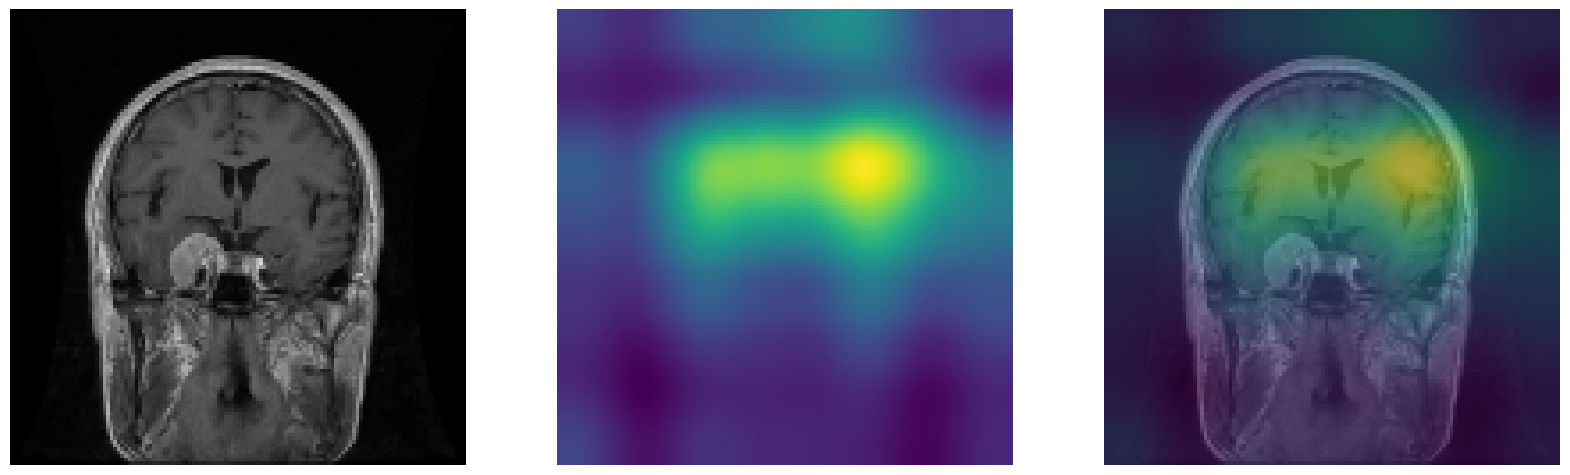

In [27]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off');
ax[0].imshow(orig_image);
ax[1].imshow(heatmap);
ax[2].imshow(output);
[axi.set_axis_off() for axi in ax.ravel()];